In [1]:
!unzip -n "/workspace/colab/pen_erazer.zip" -d "/workspace/colab/pen_erazer"

Archive:  /workspace/colab/pen_erazer.zip


In [2]:
from keras import backend as K
def m_recall(y_target,y_predict):
    true_positives=K.sum(K.round(y_target*y_predict))
    all_positives=K.sum(y_target)
    recall=true_positives/(all_positives+0.0000001)
    return recall
def m_precision(y_target,y_predict):
    true_positives=K.sum(K.round(y_target*y_predict))
    predicted_positives=K.sum(K.round(y_predict))
    recall=true_positives/(predicted_positives+0.0000001)
    return recall
def m_f1(y_target,y_predict):
    precision=m_precision(y_target,y_predict)
    recall=m_recall(y_target,y_predict)
    return 2*((precision*recall)/(precision+recall+0.0000001))
from keras import models
from keras.metrics import AUC

metric_list=['accuracy',m_recall,m_precision,m_f1,AUC(from_logits=True)]

2022-12-19 10:13:06.157992: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-19 10:13:07.512097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 10:13:07.972812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5


In [3]:
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
EPOCHS = 300
BATCH_SIZE = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_dir ="/workspace/colab/pen_erazer/pen_erazer/train"
valid_dir = "/workspace/colab/pen_erazer/pen_erazer/validation"

train_datagen=ImageDataGenerator(rescale=1./255.0,rotation_range=40,width_shift_range=0.3,height_shift_range=0.3,zoom_range=0.2,horizontal_flip=True)
valid_datagen=ImageDataGenerator(rescale=1./255.0)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=BATCH_SIZE,class_mode='binary')
valid_generator=valid_datagen.flow_from_directory(valid_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=BATCH_SIZE,class_mode='binary')


train_num = train_generator.samples
valid_num = valid_generator.samples

Found 150 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [4]:
img=load_img('/workspace/colab/pen_erazer/pen_erazer/train/pen/pen (1).jpg')

data=img_to_array(img)
img_data=np.expand_dims(data,axis=0)
sample_datagen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
train_sample_iter=sample_datagen.flow(img_data,batch_size=1)

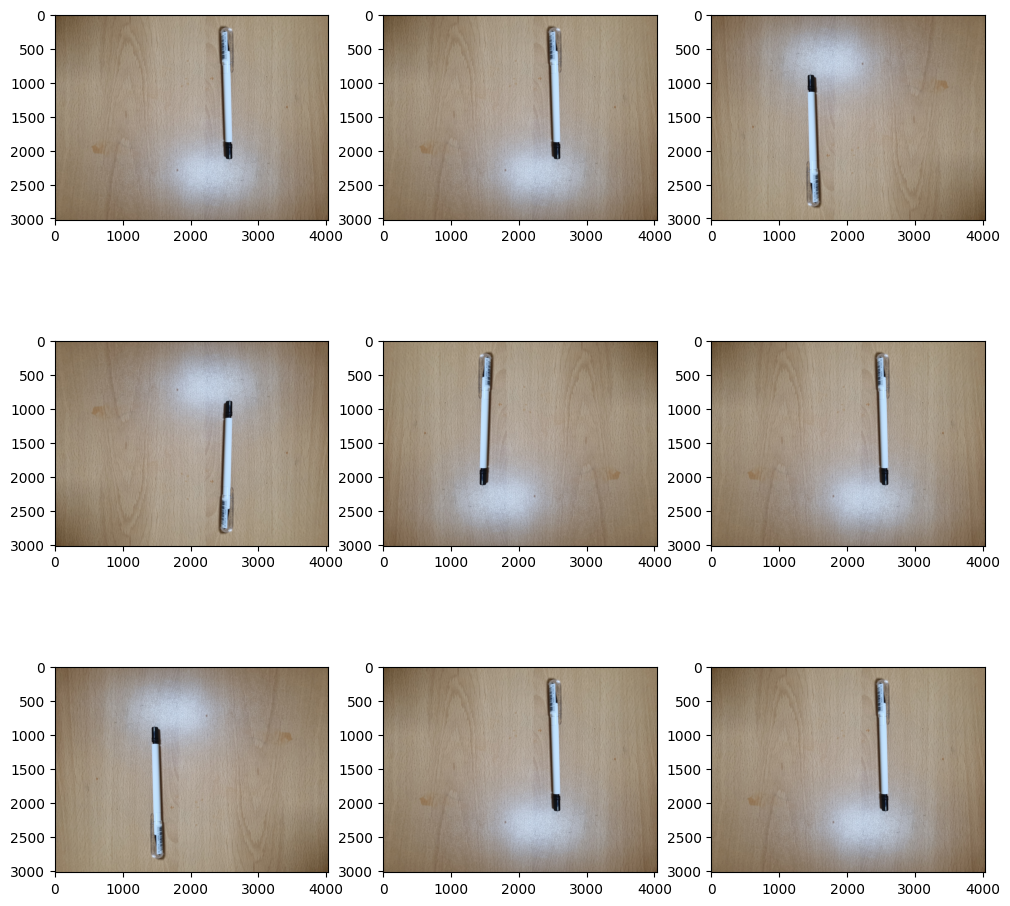

In [5]:
fig=plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    batch=next(iter(train_sample_iter))
    image=batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [6]:
from keras import models
from keras import layers
from keras.metrics import AUC

model = models.Sequential(name='pen_erazer')
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',strides=(1,1),name='CNN_Layer1',input_shape=(150,150,3)))

model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',strides=(1,1),name='CNN_Layer2'))

model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',strides=(1,1),name='CNN_Layer3'))

model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',strides=(1,1),name='CNN_Layer4'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu',name='FC_Layer1'))
model.add(layers.Dense(1,activation='sigmoid',name='FC_Layer2_Output'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metric_list)
model.summary()

Model: "pen_erazer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_Layer1 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 CNN_Layer2 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 CNN_Layer3 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [7]:
from keras.callbacks import EarlyStopping
ES_Callback = EarlyStopping(monitor='m_f1', patience=150)
history= model.fit(train_generator,steps_per_epoch=train_num//BATCH_SIZE, epochs=EPOCHS, validation_data=valid_generator, callbacks=[ES_Callback])

Epoch 1/300


2022-12-19 10:13:25.567513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


3/3 [==============================] - 13s 4s/step - loss: 0.9127 - accuracy: 0.4333 - m_recall: 0.6667 - m_precision: 0.3000 - m_f1: 0.4085 - auc: 0.4012 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_m_recall: 0.0000e+00 - val_m_precision: 0.0000e+00 - val_m_f1: 0.0000e+00 - val_auc: 0.5000
Epoch 2/300
3/3 [==============================] - 10s 4s/step - loss: 0.6966 - accuracy: 0.4867 - m_recall: 0.6667 - m_precision: 0.3267 - m_f1: 0.4375 - auc: 0.4644 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_m_recall: 1.0000 - val_m_precision: 0.5000 - val_m_f1: 0.6667 - val_auc: 0.5000
Epoch 3/300
3/3 [==============================] - 11s 4s/step - loss: 0.6936 - accuracy: 0.4867 - m_recall: 0.6667 - m_precision: 0.3267 - m_f1: 0.4381 - auc: 0.4867 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_m_recall: 0.0000e+00 - val_m_precision: 0.0000e+00 - val_m_f1: 0.0000e+00 - val_auc: 0.5000
Epoch 4/300
3/3 [==============================] - 10s 4s/step - loss: 0.6932 - accuracy: 0.5000 - m_re

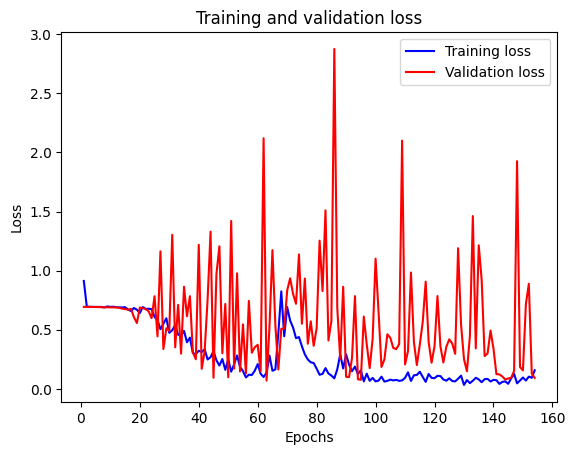

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim()
plt.show()

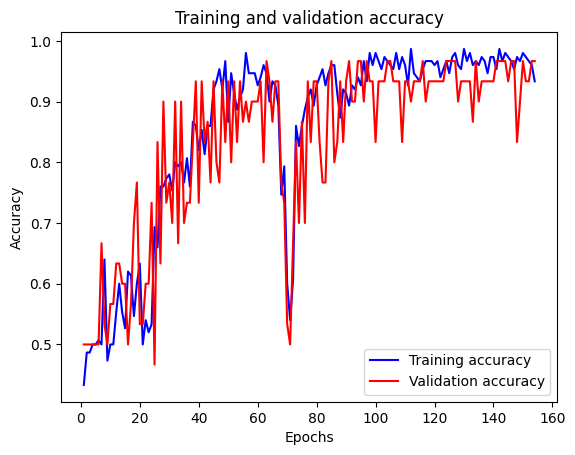

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim()
plt.show()

In [10]:
test_dir="/workspace/colab/pen_erazer/pen_erazer/test"
test_datagen=ImageDataGenerator(rescale=1./255.0)
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(150,150),color_mode="rgb",batch_size=10,class_mode='binary')
test_num=test_generator.samples

Found 21 images belonging to 2 classes.


In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from keras.metrics import AUC
test_image,test_label=next(iter(test_generator))
model.evaluate(test_image,test_label)

test_pred=model.predict(test_image)
fpr,tpr,thresholds=roc_curve(test_label,test_pred)

m=AUC(num_thresholds=200)
m.update_state(test_label,test_pred)

1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 17ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

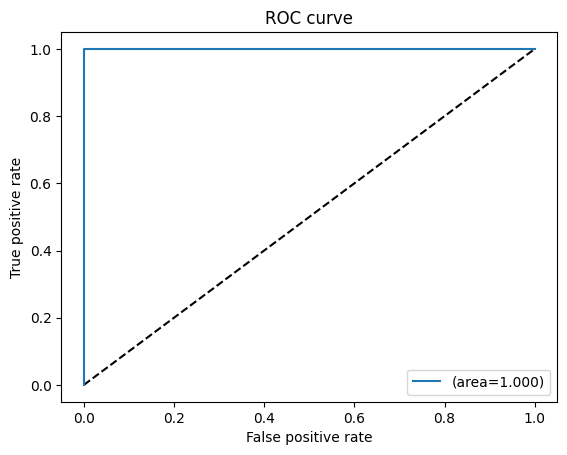

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
test_image,test_label=next(iter(test_generator))
model.evaluate(test_image,test_label)

test_pred=model.predict(test_image)
fpr,tpr,thresholds=roc_curve(test_label,test_pred)

m=AUC(num_thresholds=200)
m.update_state(test_label,test_pred)
plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='(area={:.3f})'.format(m.result()))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show

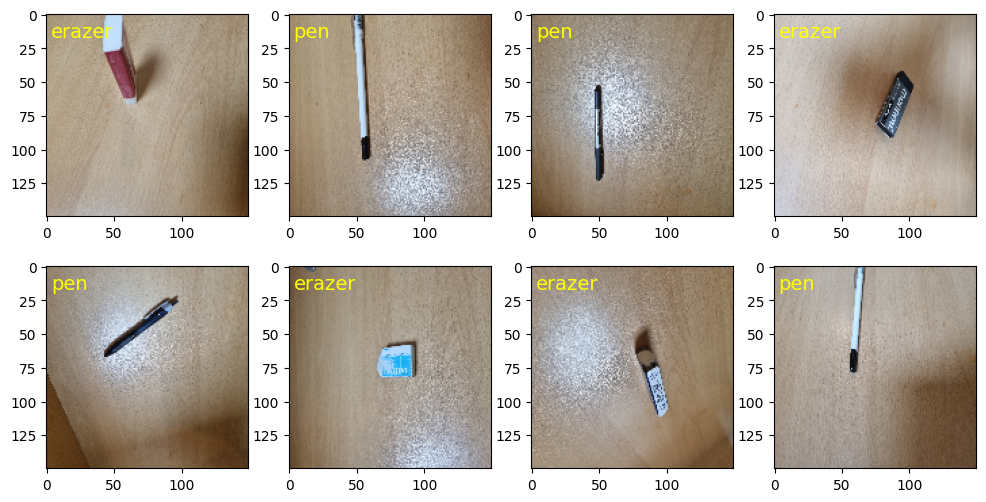

In [13]:
class_names=['erazer','pen']
test_pred=((test_pred>0.5).astype("int32")).flatten()

fig =plt.figure(figsize=(12,6))
for i in range(8):
    ax=fig.add_subplot(2,4,i+1)
    ax.imshow(test_image[i,:],cmap=plt.cm.gray_r)
    if test_pred[i]==test_label[i]:
        ax.text(3,17,class_names[test_pred[i]],color='yellow',fontsize=14)
    else:
        ax.text(3,17,class_names[test_pred[i]],color='red',fontsize=14)